Импорты используемых библиотек:

In [1]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
sns.set(style="darkgrid")
import numpy as np
from ipywidgets import interact, IntSlider, fixed, FloatSlider
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier

Загрузка датасета:

In [2]:
data_set = pd.read_csv('../data/economic_freedom.csv', encoding="ISO-8859-1")
data_set = data_set.drop(["Country", "WEBNAME"], axis=1)

Переименуем столбцы в соответствии со snake_case:

In [3]:
data_set.columns = ['id', 'name', 'region', 'world_rank',
       'region_rank', 'score', 'property_rights', 'judical_effectiveness',
       'gov_integrity', 'tax_burden', 'gov_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom ', 'financial_freedom',
       'tariff_rate', 'income_tax_rate', 'corp_tax_rate',
       'tax_burden', 'gov_expenditure',
       'population', 'gdp', 'gdp_growth_rate',
       'five_year_gdp_growth_rate', 'gdp_per_capita',
       'unemployment', 'inflation', 'fdi_inflow',
       'public_debt']

Заменим невалидные символы и удалим невалидные значения:

In [4]:
data_set.gdp = data_set.gdp.str[1:]
data_set.fdi_inflow = data_set.fdi_inflow.str[1:]
data_set.gdp_per_capita = data_set.gdp_per_capita.str[1:]
data_set.gdp = data_set.gdp.str.replace(',', '')
data_set.fdi_inflow = data_set.fdi_inflow.str.replace(',', '')
data_set.gdp_per_capita = data_set.gdp_per_capita.str.replace(',', '')

In [5]:
data_set

,id,name,region,world_rank,region_rank,score,property_rights,judical_effectiveness,gov_integrity,tax_burden,...,gov_expenditure,population,gdp,gdp_growth_rate,five_year_gdp_growth_rate,gdp_per_capita,unemployment,inflation,fdi_inflow,public_debt
0,1,Afghanistan,Asia-Pacific,152.0,39.0,51.5,19.6,29.6,25.2,91.7,...,25.6,35.5,69.6,2.5,2.9,1958,8.8,5.0,3.9,7.3
1,2,Albania,Europe,52.0,27.0,66.5,54.8,30.6,40.4,86.3,...,29.5,2.9,36.0,3.9,2.5,12507,13.9,2.0,119.1,71.2
2,3,Algeria,Middle East and North Africa,171.0,14.0,46.2,31.6,36.2,28.9,76.4,...,41.4,41.5,632.9,2.0,3.1,15237,10.0,5.6,203.0,25.8
3,4,Angola,Sub-Saharan Africa,156.0,33.0,50.6,35.9,26.6,20.5,83.9,...,25.3,28.2,190.3,0.7,2.9,6753,8.2,31.7,2254.5,65.3
4,5,Argentina,Americas,148.0,26.0,52.2,47.8,44.5,33.5,69.3,...,41.0,44.1,920.2,2.9,0.7,20876,8.7,25.7,1857.0,52.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,179,Venezuela,Americas,179.0,32.0,25.9,7.6,13.1,7.9,74.7,...,37.4,31.4,380.7,-14.0,-7.8,12114,7.7,1087.5,68.0,34.9
182,180,Vietnam,Asia-Pacific,128.0,30.0,55.3,49.8,40.3,34.0,79.7,...,29.4,93.6,647.4,6.8,6.2,6913,2.1,3.5,4100.0,58.2
183,181,Yemen,Middle East and North Africa,NaN,NaN,NaN,19.6,22.2,20.3,NaN,...,NaN,30.0,38.6,-13.8,-16.1,1287,14.0,4.9,269.9,141.0
184,182,Zambia,Sub-Saharan Africa,138.0,27.0,53.6,45.0,35.6,32.3,72.3,...,25.8,17.2,68.9,3.6,4.0,3996,7.8,6.6,091.2,62.2


Функции для вывода на экран результатов применения UMAP:

In [6]:
def make_dict(series):
    keys = list(series.value_counts().keys())
    return keys, {keys[i]:i for i in range(len(keys))}

def draw_projections(data, columns):
    fig = plt.figure(figsize=(10, 10))
    proj = '3d' if data.shape[1] == 3 else None
    a = math.ceil(math.sqrt(len(columns)))
    
    for i in range(len(columns)):
        keys, d = make_dict(data_set[columns[i]])
        colors = [sns.color_palette("husl", len(d))[x] for x in data_set[columns[i]].map(d)]
        subplot = fig.add_subplot(int(f'{a}{a}{i + 1}'), projection=proj)
        
        if data.shape[1] == 1:
            subplot.scatter(data[:, 0], c=colors)
        elif data.shape[1] == 2:
            subplot.scatter(data[:, 0], data[:, 1], c=colors)
        elif data.shape[1] == 3:
            subplot.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors) 
            
        subplot.title.set_text(f"UMAP projection by {columns[i]}")
            
        patches = [mpatches.Patch(color=sns.color_palette("hls", len(d))[i], label=keys[i]) for i in range(len(keys))]

        subplot.legend(handles=patches, ncol=10, loc="lower center")

Функция для применения UMAP и вывода результатов:

In [7]:
def draw_umap(data, columns, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', draw=True):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=42
    )
    
    result = fit.fit_transform(data)
    
    if draw:
        draw_projections(result, columns)
        plt.title(f"neighbors = {n_neighbors}, min_dist={min_dist}, components={n_components}, metric={metric}")
    
    return result

Нормируем числовые значения во всех столбцах с помощью z-score:

In [8]:
data_set = data_set.dropna()
scaled_data_values = StandardScaler().fit_transform(data_set[['property_rights', 'judical_effectiveness',
       'gov_integrity', 'tax_burden', 'gov_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom ', 'financial_freedom',
       'tariff_rate', 'income_tax_rate', 'corp_tax_rate',
       'tax_burden', 'gov_expenditure',
       'population', 'gdp', 'gdp_growth_rate',
       'five_year_gdp_growth_rate', 'gdp_per_capita',
       'unemployment', 'inflation', 'fdi_inflow',
       'public_debt']].values)

Строим проекцию исходных данных на двумерное пространство с помощью UMAP:

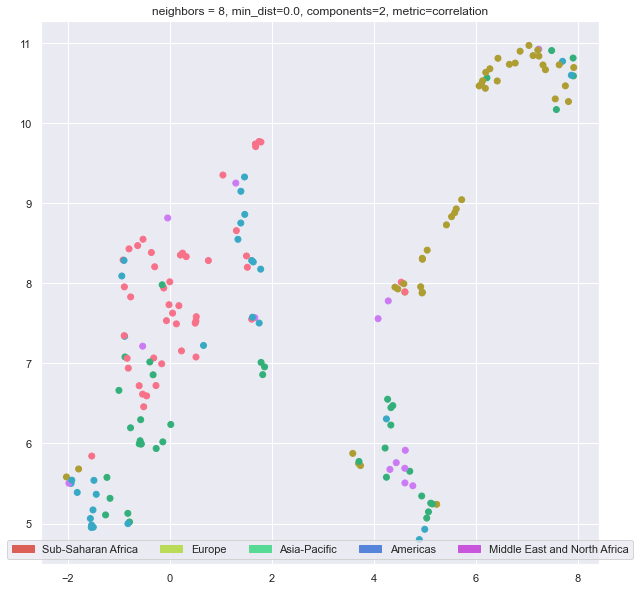

In [9]:
    projection = draw_umap(scaled_data_values, ["region"], n_neighbors=8, 
                       min_dist=0.0, n_components=2, metric='correlation')

In [28]:
train = projection[:150]
test = projection[150:]

23

In [52]:
keys, d = make_dict(data_set['region'])
marks = [x for x in data_set['region'].map(d)]
marks[150:]

[2, 2, 0, 2, 2, 0, 2, 3, 4, 1, 2, 0, 1, 4, 1, 3, 3, 2, 2, 3, 2, 0, 0]

In [49]:
knn = KNeighborsClassifier(n_neighbors=6, weights='uniform', metric='manhattan')#, algorithm='brute')
knn.fit(train, marks)
knn.predict(test)

array([2, 2, 0, 3, 4, 0, 4, 3, 3, 3, 2, 0, 4, 2, 1, 2, 1, 2, 2, 0, 2, 0,
       0])

In [47]:
def plot_knn_neigh_count(k):
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='manhattan')#, algorithm='brute')
    knn.fit(train, marks)
    x_range = np.linspace(train.min(), train.max(), 100)

    # всевозможные попарные значения признаков
    xx1, xx2 = np.meshgrid(x_range, x_range)

    Y = knn.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])[:,1]
    Y = Y.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Y, alpha=0.3)
    plt.scatter(train[:,0], train[:,1],c=marks, cmap=plt.cm.Accent);
fig = interact(plot_knn_neigh_count, k=IntSlider(min=1, max=30, value=1))

interactive(children=(IntSlider(value=1, description='k', max=30, min=1), Output()), _dom_classes=('widget-int…